In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")


!unzip '/content/gdrive/MyDrive/2.zip'



import os
a = '/content/1/test/aeroplane'
path, dirs, files = next(os.walk(a))
file_count = len(files)
print(file_count)


import torch, os
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])])


train_data_dir = "/content/1/train"

val_data_dir = "/content/1/val"
test_data_dir = "/content/1/test"
# take the dataset from the location nad transform it 
trainset = torchvision.datasets.ImageFolder(root=train_data_dir, transform=transform)
#divide the data into batches with batch_size=4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=1)
print(len(trainset))

valnset = torchvision.datasets.ImageFolder(root= val_data_dir, transform=transform)
valloader = torch.utils.data.DataLoader(valnset, batch_size=4,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.ImageFolder(root= test_data_dir , transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=1)




import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# <<<<<<<<<<<<<<<<<<<<< EDIT THE MODEL DEFINITION >>>>>>>>>>>>>>>>>>>>>>>>>>
# Try experimenting by changing the following:
# 1. number of feature maps in conv layer
# 2. Number of conv layers
# 3. Kernel size
# etc etc.,

num_epochs = 50        # desired number of training epochs.
learning_rate = 0.001   

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv6= nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        # self.conv7= nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=512, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        
        self.fc3 = nn.Linear(in_features=128, out_features=5)
         # 5 is the number of classes here (for batch 3,4,5 out_features is 33)

    def forward(self, x): 

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        x = F.relu(self.conv6(x))
        x = self.pool(x)
        # x = F.relu(self.conv7(x))
        # x = self.pool(x)
        
        
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x  

################### DO NOT EDIT THE BELOW CODE!!! #######################

net = Net()

# transfer the model to GPU
if torch.cuda.is_available():
    net = net.cuda()

########################################################################
# Define a Loss function and optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Let's use a Classification Cross-Entropy loss and SGD with momentum.

import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

num_params = np.sum([p.nelement() for p in net.parameters()])
print(num_params, ' parameters')

########################################################################
# Train the network
# ^^^^^^^^^^^^^^^^^^^^

def train(epoch, trainloader, optimizer, criterion,net):
    running_loss = 0.0
    correct=0
    total=0
    for i, data in enumerate(tqdm(trainloader), 0):
        # get the inputs
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    

    print('epoch %d training loss: %.3f' %
            (epoch + 1, running_loss / (len(trainloader))))
    print('Accuracy of the network on the train images: %f %%' % (
                                    100 * correct / total))
    return (100* correct/total)

    
########################################################################
# Let us look at how the network performs on the test dataset.

def test(testloader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the test images: %f %%' % (
                                    100 * correct / total))
    return (100* correct/total)

#########################################################################
# get details of classes and class to index mapping in a directory
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


def classwise_test(testloader, model):
########################################################################
# class-wise accuracy

    classes, _ = find_classes(train_data_dir)
    n_class = len(classes) # number of classes

    class_correct = list(0. for i in range(n_class))
    class_total = list(0. for i in range(n_class))
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(n_class):
        print('Accuracy of %10s : %2f %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

print('Start Training')
os.makedirs('./models', exist_ok=True)
train_accuracies=[]
test_accuracies=[]
val_accuracies=[]

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('epoch ', epoch + 1)
    train_accuracy=train(epoch, trainloader, optimizer, criterion,net)
    train_accuracies.append(train_accuracy)
    val_accuracy=test(valloader, net)
    val_accuracies.append(val_accuracy)
    # test_accuracy=test(testloader, net)
    # test_accuracies.append(test_accuracy)
#     classwise_test(valloader, net)
    # save model checkpoint 
    torch.save(net.state_dict(), './models/model'+str(epoch)+'.pth')      

print('performing test')
test_accuracy=test(testloader, net)
classwise_test(testloader, net)

print('Finished Training')

# Saving our trained model
torch.save(net.state_dict(), './models/bestmodelconv5.pth')


Streaming output truncated to the last 5000 lines.
 extracting: 1/train/bird/bird_s_001708.png  
 extracting: 1/train/bird/emu_s_000219.png  
 extracting: 1/train/bird/pipit_s_000192.png  
 extracting: 1/train/bird/flightless_bird_s_000562.png  
 extracting: 1/train/bird/passerine_s_001221.png  
 extracting: 1/train/bird/struthio_camelus_s_000008.png  
  inflating: 1/train/bird/pipit_s_000221.png  
 extracting: 1/train/bird/passerine_s_001226.png  
 extracting: 1/train/bird/emu_s_001158.png  
 extracting: 1/train/bird/accentor_s_000039.png  
 extracting: 1/train/bird/pipit_s_000029.png  
 extracting: 1/train/bird/ostrich_s_002262.png  
 extracting: 1/train/bird/struthio_camelus_s_000156.png  
  inflating: 1/train/bird/flightless_bird_s_000353.png  
 extracting: 1/train/bird/pipit_s_000443.png  
 extracting: 1/train/bird/ostrich_s_000506.png  
  inflating: 1/train/bird/sparrow_s_000490.png  
  inflating: 1/train/bird/ostrich_s_002057.png  
  inflating: 1/train/bird/meadow_pipit_s_000610

100%|██████████| 6250/6250 [00:49<00:00, 126.24it/s]


epoch 1 training loss: 1.610
Accuracy of the network on the train images: 19.792000 %


100%|██████████| 625/625 [00:03<00:00, 190.53it/s]


Accuracy of the network on the test images: 20.000000 %
epoch  2


100%|██████████| 6250/6250 [00:49<00:00, 125.97it/s]


epoch 2 training loss: 1.504
Accuracy of the network on the train images: 26.908000 %


100%|██████████| 625/625 [00:03<00:00, 192.53it/s]


Accuracy of the network on the test images: 33.840000 %
epoch  3


100%|██████████| 6250/6250 [00:49<00:00, 126.67it/s]


epoch 3 training loss: 1.214
Accuracy of the network on the train images: 39.128000 %


100%|██████████| 625/625 [00:03<00:00, 194.23it/s]


Accuracy of the network on the test images: 43.640000 %
epoch  4


100%|██████████| 6250/6250 [00:49<00:00, 126.39it/s]


epoch 4 training loss: 1.076
Accuracy of the network on the train images: 51.012000 %


100%|██████████| 625/625 [00:03<00:00, 195.98it/s]


Accuracy of the network on the test images: 54.160000 %
epoch  5


100%|██████████| 6250/6250 [00:48<00:00, 127.80it/s]


epoch 5 training loss: 0.932
Accuracy of the network on the train images: 59.816000 %


100%|██████████| 625/625 [00:03<00:00, 192.02it/s]


Accuracy of the network on the test images: 65.960000 %
epoch  6


100%|██████████| 6250/6250 [00:50<00:00, 124.88it/s]


epoch 6 training loss: 0.804
Accuracy of the network on the train images: 66.928000 %


100%|██████████| 625/625 [00:03<00:00, 194.80it/s]


Accuracy of the network on the test images: 70.720000 %
epoch  7


100%|██████████| 6250/6250 [00:49<00:00, 125.06it/s]


epoch 7 training loss: 0.685
Accuracy of the network on the train images: 72.428000 %


100%|██████████| 625/625 [00:03<00:00, 194.33it/s]


Accuracy of the network on the test images: 71.600000 %
epoch  8


100%|██████████| 6250/6250 [00:48<00:00, 128.56it/s]


epoch 8 training loss: 0.592
Accuracy of the network on the train images: 76.560000 %


100%|██████████| 625/625 [00:04<00:00, 139.55it/s]


Accuracy of the network on the test images: 75.960000 %
epoch  9


100%|██████████| 6250/6250 [00:47<00:00, 130.42it/s]


epoch 9 training loss: 0.506
Accuracy of the network on the train images: 80.364000 %


100%|██████████| 625/625 [00:03<00:00, 194.80it/s]


Accuracy of the network on the test images: 75.000000 %
epoch  10


100%|██████████| 6250/6250 [00:49<00:00, 127.37it/s]


epoch 10 training loss: 0.429
Accuracy of the network on the train images: 83.232000 %


100%|██████████| 625/625 [00:03<00:00, 192.72it/s]


Accuracy of the network on the test images: 77.280000 %
epoch  11


100%|██████████| 6250/6250 [00:49<00:00, 125.91it/s]


epoch 11 training loss: 0.363
Accuracy of the network on the train images: 85.928000 %


100%|██████████| 625/625 [00:03<00:00, 195.62it/s]


Accuracy of the network on the test images: 78.360000 %
epoch  12


100%|██████████| 6250/6250 [00:47<00:00, 131.20it/s]


epoch 12 training loss: 0.291
Accuracy of the network on the train images: 89.092000 %


100%|██████████| 625/625 [00:03<00:00, 198.05it/s]


Accuracy of the network on the test images: 76.200000 %
epoch  13


100%|██████████| 6250/6250 [00:49<00:00, 127.45it/s]


epoch 13 training loss: 0.243
Accuracy of the network on the train images: 90.696000 %


100%|██████████| 625/625 [00:03<00:00, 187.82it/s]


Accuracy of the network on the test images: 78.400000 %
epoch  14


100%|██████████| 6250/6250 [00:49<00:00, 125.80it/s]


epoch 14 training loss: 0.201
Accuracy of the network on the train images: 92.560000 %


100%|██████████| 625/625 [00:03<00:00, 196.18it/s]


Accuracy of the network on the test images: 79.120000 %
epoch  15


100%|██████████| 6250/6250 [00:48<00:00, 128.07it/s]


epoch 15 training loss: 0.172
Accuracy of the network on the train images: 93.824000 %


100%|██████████| 625/625 [00:04<00:00, 151.18it/s]


Accuracy of the network on the test images: 77.160000 %
epoch  16


100%|██████████| 6250/6250 [00:47<00:00, 130.27it/s]


epoch 16 training loss: 0.142
Accuracy of the network on the train images: 94.872000 %


100%|██████████| 625/625 [00:03<00:00, 192.49it/s]


Accuracy of the network on the test images: 78.200000 %
epoch  17


100%|██████████| 6250/6250 [00:49<00:00, 125.21it/s]


epoch 17 training loss: 0.126
Accuracy of the network on the train images: 95.556000 %


100%|██████████| 625/625 [00:03<00:00, 194.85it/s]


Accuracy of the network on the test images: 78.360000 %
epoch  18


100%|██████████| 6250/6250 [00:48<00:00, 127.93it/s]


epoch 18 training loss: 0.111
Accuracy of the network on the train images: 96.036000 %


100%|██████████| 625/625 [00:03<00:00, 196.43it/s]


Accuracy of the network on the test images: 76.840000 %
epoch  19


100%|██████████| 6250/6250 [00:47<00:00, 130.75it/s]


epoch 19 training loss: 0.097
Accuracy of the network on the train images: 96.464000 %


100%|██████████| 625/625 [00:03<00:00, 197.51it/s]


Accuracy of the network on the test images: 78.920000 %
epoch  20


100%|██████████| 6250/6250 [00:48<00:00, 127.58it/s]


epoch 20 training loss: 0.080
Accuracy of the network on the train images: 97.256000 %


100%|██████████| 625/625 [00:03<00:00, 198.11it/s]


Accuracy of the network on the test images: 78.120000 %
epoch  21


100%|██████████| 6250/6250 [00:49<00:00, 126.39it/s]


epoch 21 training loss: 0.072
Accuracy of the network on the train images: 97.612000 %


100%|██████████| 625/625 [00:03<00:00, 194.16it/s]


Accuracy of the network on the test images: 77.640000 %
epoch  22


100%|██████████| 6250/6250 [00:47<00:00, 130.36it/s]


epoch 22 training loss: 0.079
Accuracy of the network on the train images: 97.168000 %


100%|██████████| 625/625 [00:03<00:00, 195.64it/s]


Accuracy of the network on the test images: 79.560000 %
epoch  23


100%|██████████| 6250/6250 [00:49<00:00, 125.21it/s]


epoch 23 training loss: 0.071
Accuracy of the network on the train images: 97.536000 %


100%|██████████| 625/625 [00:03<00:00, 197.03it/s]


Accuracy of the network on the test images: 78.360000 %
epoch  24


100%|██████████| 6250/6250 [00:49<00:00, 127.21it/s]


epoch 24 training loss: 0.064
Accuracy of the network on the train images: 97.756000 %


100%|██████████| 625/625 [00:03<00:00, 196.18it/s]


Accuracy of the network on the test images: 79.560000 %
epoch  25


100%|██████████| 6250/6250 [00:48<00:00, 128.92it/s]


epoch 25 training loss: 0.063
Accuracy of the network on the train images: 97.840000 %


100%|██████████| 625/625 [00:03<00:00, 161.46it/s]


Accuracy of the network on the test images: 78.880000 %
epoch  26


100%|██████████| 6250/6250 [00:48<00:00, 130.00it/s]


epoch 26 training loss: 0.050
Accuracy of the network on the train images: 98.300000 %


100%|██████████| 625/625 [00:03<00:00, 195.63it/s]


Accuracy of the network on the test images: 79.280000 %
epoch  27


100%|██████████| 6250/6250 [00:49<00:00, 126.90it/s]


epoch 27 training loss: 0.055
Accuracy of the network on the train images: 98.116000 %


100%|██████████| 625/625 [00:03<00:00, 196.05it/s]


Accuracy of the network on the test images: 79.000000 %
epoch  28


100%|██████████| 6250/6250 [00:49<00:00, 127.18it/s]


epoch 28 training loss: 0.054
Accuracy of the network on the train images: 98.124000 %


100%|██████████| 625/625 [00:03<00:00, 195.51it/s]


Accuracy of the network on the test images: 79.960000 %
epoch  29


100%|██████████| 6250/6250 [00:48<00:00, 129.14it/s]


epoch 29 training loss: 0.050
Accuracy of the network on the train images: 98.280000 %


100%|██████████| 625/625 [00:03<00:00, 195.47it/s]


Accuracy of the network on the test images: 79.320000 %
epoch  30


100%|██████████| 6250/6250 [00:49<00:00, 127.17it/s]


epoch 30 training loss: 0.046
Accuracy of the network on the train images: 98.432000 %


100%|██████████| 625/625 [00:03<00:00, 194.81it/s]


Accuracy of the network on the test images: 79.880000 %
epoch  31


100%|██████████| 6250/6250 [00:48<00:00, 127.74it/s]


epoch 31 training loss: 0.049
Accuracy of the network on the train images: 98.268000 %


100%|██████████| 625/625 [00:03<00:00, 197.91it/s]


Accuracy of the network on the test images: 78.400000 %
epoch  32


100%|██████████| 6250/6250 [00:47<00:00, 130.83it/s]


epoch 32 training loss: 0.053
Accuracy of the network on the train images: 98.184000 %


100%|██████████| 625/625 [00:03<00:00, 193.86it/s]


Accuracy of the network on the test images: 77.920000 %
epoch  33


100%|██████████| 6250/6250 [00:49<00:00, 127.45it/s]


epoch 33 training loss: 0.043
Accuracy of the network on the train images: 98.500000 %


100%|██████████| 625/625 [00:03<00:00, 196.53it/s]


Accuracy of the network on the test images: 80.880000 %
epoch  34


100%|██████████| 6250/6250 [00:49<00:00, 127.40it/s]


epoch 34 training loss: 0.047
Accuracy of the network on the train images: 98.408000 %


100%|██████████| 625/625 [00:03<00:00, 195.59it/s]


Accuracy of the network on the test images: 79.040000 %
epoch  35


100%|██████████| 6250/6250 [00:49<00:00, 125.85it/s]


epoch 35 training loss: 0.044
Accuracy of the network on the train images: 98.544000 %


100%|██████████| 625/625 [00:03<00:00, 199.09it/s]


Accuracy of the network on the test images: 80.600000 %
epoch  36


100%|██████████| 6250/6250 [00:47<00:00, 130.81it/s]


epoch 36 training loss: 0.042
Accuracy of the network on the train images: 98.564000 %


100%|██████████| 625/625 [00:03<00:00, 196.29it/s]


Accuracy of the network on the test images: 80.880000 %
epoch  37


100%|██████████| 6250/6250 [00:48<00:00, 127.97it/s]


epoch 37 training loss: 0.043
Accuracy of the network on the train images: 98.552000 %


100%|██████████| 625/625 [00:03<00:00, 193.21it/s]


Accuracy of the network on the test images: 80.400000 %
epoch  38


100%|██████████| 6250/6250 [00:48<00:00, 128.66it/s]


epoch 38 training loss: 0.047
Accuracy of the network on the train images: 98.512000 %


100%|██████████| 625/625 [00:03<00:00, 199.31it/s]


Accuracy of the network on the test images: 78.960000 %
epoch  39


100%|██████████| 6250/6250 [00:47<00:00, 131.67it/s]


epoch 39 training loss: 0.036
Accuracy of the network on the train images: 98.848000 %


100%|██████████| 625/625 [00:03<00:00, 198.84it/s]


Accuracy of the network on the test images: 78.800000 %
epoch  40


100%|██████████| 6250/6250 [00:48<00:00, 128.19it/s]


epoch 40 training loss: 0.050
Accuracy of the network on the train images: 98.248000 %


100%|██████████| 625/625 [00:03<00:00, 197.82it/s]


Accuracy of the network on the test images: 78.240000 %
epoch  41


100%|██████████| 6250/6250 [00:49<00:00, 126.56it/s]


epoch 41 training loss: 0.044
Accuracy of the network on the train images: 98.548000 %


100%|██████████| 625/625 [00:03<00:00, 195.35it/s]


Accuracy of the network on the test images: 79.320000 %
epoch  42


100%|██████████| 6250/6250 [00:47<00:00, 131.34it/s]


epoch 42 training loss: 0.042
Accuracy of the network on the train images: 98.604000 %


100%|██████████| 625/625 [00:03<00:00, 197.88it/s]


Accuracy of the network on the test images: 80.160000 %
epoch  43


100%|██████████| 6250/6250 [00:49<00:00, 127.41it/s]


epoch 43 training loss: 0.043
Accuracy of the network on the train images: 98.584000 %


100%|██████████| 625/625 [00:03<00:00, 194.56it/s]


Accuracy of the network on the test images: 81.360000 %
epoch  44


100%|██████████| 6250/6250 [00:48<00:00, 127.91it/s]


epoch 44 training loss: 0.037
Accuracy of the network on the train images: 98.732000 %


100%|██████████| 625/625 [00:03<00:00, 194.86it/s]


Accuracy of the network on the test images: 80.320000 %
epoch  45


100%|██████████| 6250/6250 [00:47<00:00, 131.44it/s]


epoch 45 training loss: 0.035
Accuracy of the network on the train images: 98.804000 %


100%|██████████| 625/625 [00:03<00:00, 176.93it/s]


Accuracy of the network on the test images: 79.160000 %
epoch  46


100%|██████████| 6250/6250 [00:48<00:00, 128.34it/s]


epoch 46 training loss: 0.041
Accuracy of the network on the train images: 98.612000 %


100%|██████████| 625/625 [00:03<00:00, 197.78it/s]


Accuracy of the network on the test images: 78.680000 %
epoch  47


100%|██████████| 6250/6250 [00:49<00:00, 125.70it/s]


epoch 47 training loss: 0.034
Accuracy of the network on the train images: 98.844000 %


100%|██████████| 625/625 [00:03<00:00, 197.01it/s]


Accuracy of the network on the test images: 79.520000 %
epoch  48


100%|██████████| 6250/6250 [00:48<00:00, 127.56it/s]


epoch 48 training loss: 0.031
Accuracy of the network on the train images: 98.984000 %


100%|██████████| 625/625 [00:03<00:00, 198.50it/s]


Accuracy of the network on the test images: 80.160000 %
epoch  49


100%|██████████| 6250/6250 [00:47<00:00, 130.47it/s]


epoch 49 training loss: 0.042
Accuracy of the network on the train images: 98.604000 %


100%|██████████| 625/625 [00:03<00:00, 196.15it/s]


Accuracy of the network on the test images: 79.120000 %
epoch  50


100%|██████████| 6250/6250 [00:48<00:00, 127.69it/s]


epoch 50 training loss: 0.045
Accuracy of the network on the train images: 98.448000 %


100%|██████████| 625/625 [00:03<00:00, 194.88it/s]


Accuracy of the network on the test images: 80.520000 %
performing test


100%|██████████| 625/625 [00:03<00:00, 194.07it/s]


Accuracy of the network on the test images: 78.960000 %


100%|██████████| 625/625 [00:03<00:00, 191.33it/s]

Accuracy of  aeroplane : 84.400000 %
Accuracy of       bird : 80.200000 %
Accuracy of        cat : 73.600000 %
Accuracy of        dog : 66.600000 %
Accuracy of       ship : 90.000000 %
Finished Training


In [ ]:
print(len(train_accuracies))
print(len(val_accuracies))
with open(r'trainconv5.txt', 'w') as fp:
  for item in train_accuracies:
     fp.write("%s\n" % item)

50
50


In [ ]:
with open(r'valconv5.txt', 'w') as fp:
  for item in train_accuracies:
     fp.write("%s\n" % item)

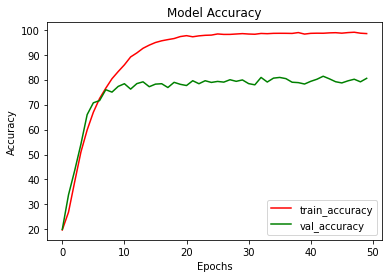

In [ ]:
epochs= np.arange(0, 50, 1)
import numpy as np  
# Assign variables to the y axis part of the curve
y = train_accuracies
z = val_accuracies
  
# Plotting both the curves simultaneously
plt.plot(epochs, y, color='r', label='train_accuracy')
plt.plot(epochs, z, color='g', label='val_accuracy')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

In [5]:
import torch, os
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random

import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# <<<<<<<<<<<<<<<<<<<<< EDIT THE MODEL DEFINITION >>>>>>>>>>>>>>>>>>>>>>>>>>
# Try experimenting by changing the following:
# 1. number of feature maps in conv layer
# 2. Number of conv layers
# 3. Kernel size
# etc etc.,

num_epochs = 50        # desired number of training epochs.
learning_rate = 0.001   

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv6= nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        # self.conv7= nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=512, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        
        self.fc3 = nn.Linear(in_features=128, out_features=5)
         # 5 is the number of classes here (for batch 3,4,5 out_features is 33)

    def forward(self, x): 

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        x = F.relu(self.conv6(x))
        x = self.pool(x)
        # x = F.relu(self.conv7(x))
        # x = self.pool(x)
        
        
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x  

################### DO NOT EDIT THE BELOW CODE!!! #######################

net = Net()

# transfer the model to GPU
if torch.cuda.is_available():
    net = net.cuda()

########################################################################
# Define a Loss function and optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


In [6]:
from torchsummary import summary
summary(net,(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
         MaxPool2d-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
         MaxPool2d-8            [-1, 256, 4, 4]               0
            Conv2d-9            [-1, 256, 4, 4]         590,080
        MaxPool2d-10            [-1, 256, 2, 2]               0
           Conv2d-11            [-1, 512, 2, 2]       1,180,160
        MaxPool2d-12            [-1, 512, 1, 1]               0
           Linear-13                  [-1, 256]         131,328
           Linear-14                  [